# HOUSE_PRICE

在参考之前的https://www.kaggle.com/serigne/stacked-regressions-top-4-on-leaderboard?scriptVersionId=1955054文档后，个人的解决方案如下：

## 整体分为：
* 查看数据
* 特征工程
* 构建模型及预测

### 查看数据
* 数据类型
* 缺失值
* 异常值检测
* 预测值正态化校验
* 相关性检测

![](./数据查看.png)

#### 查看数据

In [23]:
import pandas as pd
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt
import matplotlib as mplt
#不显示warn信息
import warnings
import missingno as msno
from sklearn import preprocessing
pd.options.mode.chained_assignment = None
warnings.filterwarnings("ignore", category=DeprecationWarning)
%matplotlib inline


In [20]:
newline = '\n'
forward_color = "\033[1;31;40m"
backward_color = "\033[0m"

In [21]:
def show_special_text(text):
    return forward_color+str(text)+backward_color

In [24]:
def glance_data(data):
    print('-----查看数据的前五行----')
    print(data.head(),newline)
    print('-----查看数据是否有缺失值，类型，记录的总数----')
    data.info()
    print(newline)
    print('-----查看数据缺失值情况--------')
    print(data.isnull().sum())

In [3]:
#单个列数据的详情
def see_column_detail(data,column):
    print('------------',column,'列详情---------------')
    #查看该列的数据类型
    print(column,'数据类型是：',show_special_text(data[column].dtype))

    #查看该列共有多少种取值个数
    cols_possible_value_count = data[column].value_counts().count()
    print(column,'共有',show_special_text(cols_possible_value_count),'种取值',newline)

    print(column,'每个取值有分布情况-----')
    if cols_possible_value_count <= 15:
        print(data[column].value_counts())
    else:
        print(data[column].value_counts().head(15))
    print(newline)
    print(column,'共有',show_special_text(data[column].isnull().sum()),'个缺失值')
    print(newline)

In [18]:
#指定n列数据的查看，默认展示前100列的情况
def see_columns_detail(data,columns=[]):
    i = 0
    if len(columns)==0:
        columns = data.columns
    if len(columns) <= 100:
        for column in columns:
            see_column_detail(data,column)
    else:
        if i <= 100:
            for column in columns:
                see_column_detail(data,column)
                i += 1

#### 查看数据缺失情况
* 图形化展示
* 表格展示

In [5]:
# 通过第三方库missingon展示缺失值情况：
def bulid_graph_missing_data(train):
    msno.matrix(train,figsize=(12,5))

In [7]:
# 显示每列缺失值的具体比例情况：
def missing_data_percent(train):
    total = train.isnull().sum().sort_values(ascending=False)
    percent = (train.isnull().sum()/train.shape[0]).sort_values(ascending=False)
    missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    print(missing_data.head(20))

#### 异常值检测
* 箱线图
* 多元统计分析

##### 箱线图

In [8]:
def build_box_plot(x_data, y_data, x_label, y_label, title):
    _, ax = plt.subplots()
    # 设置样式
    ax.boxplot(y_data
               # 箱子是否颜色填充
               , patch_artist = True
               # 中位数线颜色
               , medianprops = {'color': 'r'}
               # 箱子颜色设置，color：边框颜色，facecolor：填充颜色
               , boxprops = {'color': 'r', 'facecolor': 'b'}
               # 猫须颜色whisker
               , whiskerprops = {'color': 'b'}
               # 猫须界限颜色whisker cap
               , capprops = {'color': 'b'}
               , sym='ro')
               

    # 箱图与x_data保持一致
    ax.set_xticklabels(x_data)
    ax.set_ylabel(y_label)
    ax.set_xlabel(x_label)
    ax.set_title(title)

##### 多元统计分析——步骤
* 每个变量的点图
* 每对变量的散布图
* 检查标准化值中的最大最小值
* 计算广义平方距离

In [9]:
#计算z-score值
def z_score(train):
    scaler = preprocessing.StandardScaler().fit(train)
    print(scaler.transform(train))

In [29]:
#画每对变量的分布图
def distrub_graph(df,cols=[]):
    if len(cols)==0:
        cols = df.columns
    sns.set()
#     cols = ['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', 'FullBath', 'YearBuilt']
    sns.pairplot(df[cols], size = 2.5)
    plt.show();

##### 计算马氏距离(广义平方距离)
参考文章https://my.oschina.net/dfsj66011/blog/793392

In [12]:
def ma_dis(df,n_outliers):
    m_dist_order =  Series([float(distance.mahalanobis(hw.iloc[i], hw.mean(), np.mat(hw.cov().as_matrix()).I) ** 2)
       for i in range(len(hw))]).sort_values(ascending=False).index.tolist()
    is_outlier = [False, ] * 16
    for i in range(n_outliers):
        is_outlier[m_dist_order[i]] = True
    color = ['g', 'r']
    pch = [1 if is_outlier[i] == True else 0 for i in range(len(is_outlier))]
    cValue = [color[is_outlier[i]] for i in range(len(is_outlier))]
    fig = plt.figure()
    plt.title('Scatter Plot')
    plt.xlabel('Height_cm')
    plt.ylabel('Weight_kg')
    plt.scatter(hw['Height_cm'], hw['Weight_kg'], s=40, c=cValue)
    plt.show()

#### 查看预测值分布
* 绘制分布图
* 绘制Q-Q图
* 计算峰度/偏峰值

In [13]:
def build_normal_graph(df,col,y_lable,title):
    sns.distplot(df['SalePrice'] , fit=norm)
    #
    print('------------偏斜值/峰度------------')
    print(newline)
    print("Skewness: %f" % df_train['SalePrice'].skew())
    print("Kurtosis: %f" % df_train['SalePrice'].kurt())
    print(newline)
    (mu, sigma) = norm.fit(df['SalePrice'])
    print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))
    plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
                loc='best')
    plt.ylabel(y_lable)
    plt.title(title)
    print('Q-Q图'+newline)
    fig = plt.figure()
    res = stats.probplot(df['SalePrice'], plot=plt)
    plt.show()

In [ ]:
#分布图
sns.distplot(train['SalePrice'] , fit=norm)
(mu, sigma) = norm.fit(train['SalePrice'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')
fig = plt.figure()
res = stats.probplot(train['SalePrice'], plot=plt)
plt.show()


#### 热力图

In [14]:
def heatmap_graph(df_cols):
#     corrMatt = train[["temp","atemp","casual","registered","humidity","windspeed","count"]].corr()
    corrMatt = df_cols.corr()
    mask = np.array(corrMatt)
    mask[np.tril_indices_from(mask)] = False
    fig,ax= plt.subplots()
    fig.set_size_inches(20,10)
    sns.heatmap(corrMatt, mask=mask,vmax=.8, square=True,annot=True)

### 读取train_data分别做上述处理

In [15]:
train = pd.read_csv('./data/train.csv')

In [25]:
glance_data(train)

-----查看数据的前五行----
   Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities    ...     PoolArea PoolQC Fence MiscFeature MiscVal  \
0         Lvl    AllPub    ...            0    NaN   NaN         NaN       0   
1         Lvl    AllPub    ...            0    NaN   NaN         NaN       0   
2         Lvl    AllPub    ...            0    NaN   NaN         NaN       0   
3         Lvl    AllPub    ...            0    NaN   NaN         NaN       0   
4         Lvl    AllPub    ...            0    NaN   NaN         NaN       0   

  MoSold YrSold  SaleType  SaleCondition  SalePrice  
0 

In [22]:
see_columns_detail(train)

------------ Id 列详情---------------
Id 数据类型是： int64
Id 共有 1460 种取值 

Id 每个取值有分布情况-----
1460    1
479     1
481     1
482     1
483     1
484     1
485     1
486     1
487     1
488     1
489     1
490     1
491     1
492     1
493     1
Name: Id, dtype: int64


Id 共有 0 个缺失值


------------ MSSubClass 列详情---------------
MSSubClass 数据类型是： int64
MSSubClass 共有 15 种取值 

MSSubClass 每个取值有分布情况-----
20     536
60     299
50     144
120     87
30      69
160     63
70      60
80      58
90      52
190     30
85      20
75      16
45      12
180     10
40       4
Name: MSSubClass, dtype: int64


MSSubClass 共有 0 个缺失值


------------ MSZoning 列详情---------------
MSZoning 数据类型是： object
MSZoning 共有 5 种取值 

MSZoning 每个取值有分布情况-----
RL         1151
RM          218
FV           65
RH           16
C (all)      10
Name: MSZoning, dtype: int64


MSZoning 共有 0 个缺失值


------------ LotFrontage 列详情---------------
LotFrontage 数据类型是： float64
LotFrontage 共有 110 种取值 

LotFrontage 每个取值有分布情况-----
60.0    143
70.0     70




------------ BsmtFinType1 列详情---------------
BsmtFinType1 数据类型是： object
BsmtFinType1 共有 6 种取值 

BsmtFinType1 每个取值有分布情况-----
Unf    430
GLQ    418
ALQ    220
BLQ    148
Rec    133
LwQ     74
Name: BsmtFinType1, dtype: int64


BsmtFinType1 共有 37 个缺失值


------------ BsmtFinSF1 列详情---------------
BsmtFinSF1 数据类型是： int64
BsmtFinSF1 共有 637 种取值 

BsmtFinSF1 每个取值有分布情况-----
0       467
24       12
16        9
20        5
686       5
616       5
936       5
662       5
428       4
655       4
442       4
1200      4
400       4
300       4
312       4
Name: BsmtFinSF1, dtype: int64


BsmtFinSF1 共有 0 个缺失值


------------ BsmtFinType2 列详情---------------
BsmtFinType2 数据类型是： object
BsmtFinType2 共有 6 种取值 

BsmtFinType2 每个取值有分布情况-----
Unf    1256
Rec      54
LwQ      46
BLQ      33
ALQ      19
GLQ      14
Name: BsmtFinType2, dtype: int64


BsmtFinType2 共有 38 个缺失值


------------ BsmtFinSF2 列详情---------------
BsmtFinSF2 数据类型是： int64
BsmtFinSF2 共有 144 种取值 

BsmtFinSF2 每个取值有分布情况-----
0      1293
180     

------------ PoolQC 列详情---------------
PoolQC 数据类型是： object
PoolQC 共有 3 种取值 

PoolQC 每个取值有分布情况-----
Gd    3
Fa    2
Ex    2
Name: PoolQC, dtype: int64


PoolQC 共有 1453 个缺失值


------------ Fence 列详情---------------
Fence 数据类型是： object
Fence 共有 4 种取值 

Fence 每个取值有分布情况-----
MnPrv    157
GdPrv     59
GdWo      54
MnWw      11
Name: Fence, dtype: int64


Fence 共有 1179 个缺失值


------------ MiscFeature 列详情---------------
MiscFeature 数据类型是： object
MiscFeature 共有 4 种取值 

MiscFeature 每个取值有分布情况-----
Shed    49
Othr     2
Gar2     2
TenC     1
Name: MiscFeature, dtype: int64


MiscFeature 共有 1406 个缺失值


------------ MiscVal 列详情---------------
MiscVal 数据类型是： int64
MiscVal 共有 21 种取值 

MiscVal 每个取值有分布情况-----
0        1408
400        11
500         8
700         5
450         4
2000        4
600         4
1200        2
480         2
1150        1
800         1
15500       1
620         1
3500        1
560         1
Name: MiscVal, dtype: int64


MiscVal 共有 0 个缺失值


------------ MoSold 列详情---------------


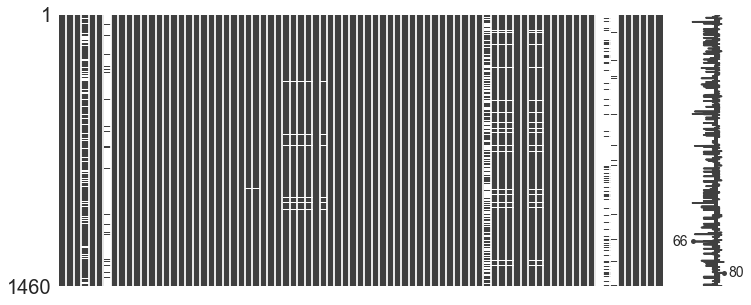

In [26]:
bulid_graph_missing_data(train)

In [27]:
missing_data_percent(train)

              Total   Percent
PoolQC         1453  0.995205
MiscFeature    1406  0.963014
Alley          1369  0.937671
Fence          1179  0.807534
FireplaceQu     690  0.472603
LotFrontage     259  0.177397
GarageCond       81  0.055479
GarageType       81  0.055479
GarageYrBlt      81  0.055479
GarageFinish     81  0.055479
GarageQual       81  0.055479
BsmtExposure     38  0.026027
BsmtFinType2     38  0.026027
BsmtFinType1     37  0.025342
BsmtCond         37  0.025342
BsmtQual         37  0.025342
MasVnrArea        8  0.005479
MasVnrType        8  0.005479
Electrical        1  0.000685
Utilities         0  0.000000


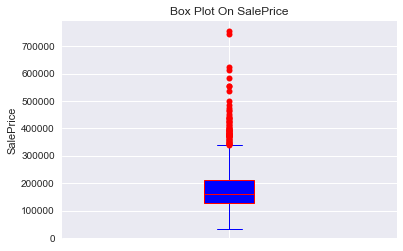

In [28]:
y_data = train['SalePrice']
x=''
x_label = ''
y_label = 'SalePrice'
title = 'Box Plot On SalePrice'
build_box_plot(x,y_data,x_label,y_label,title)

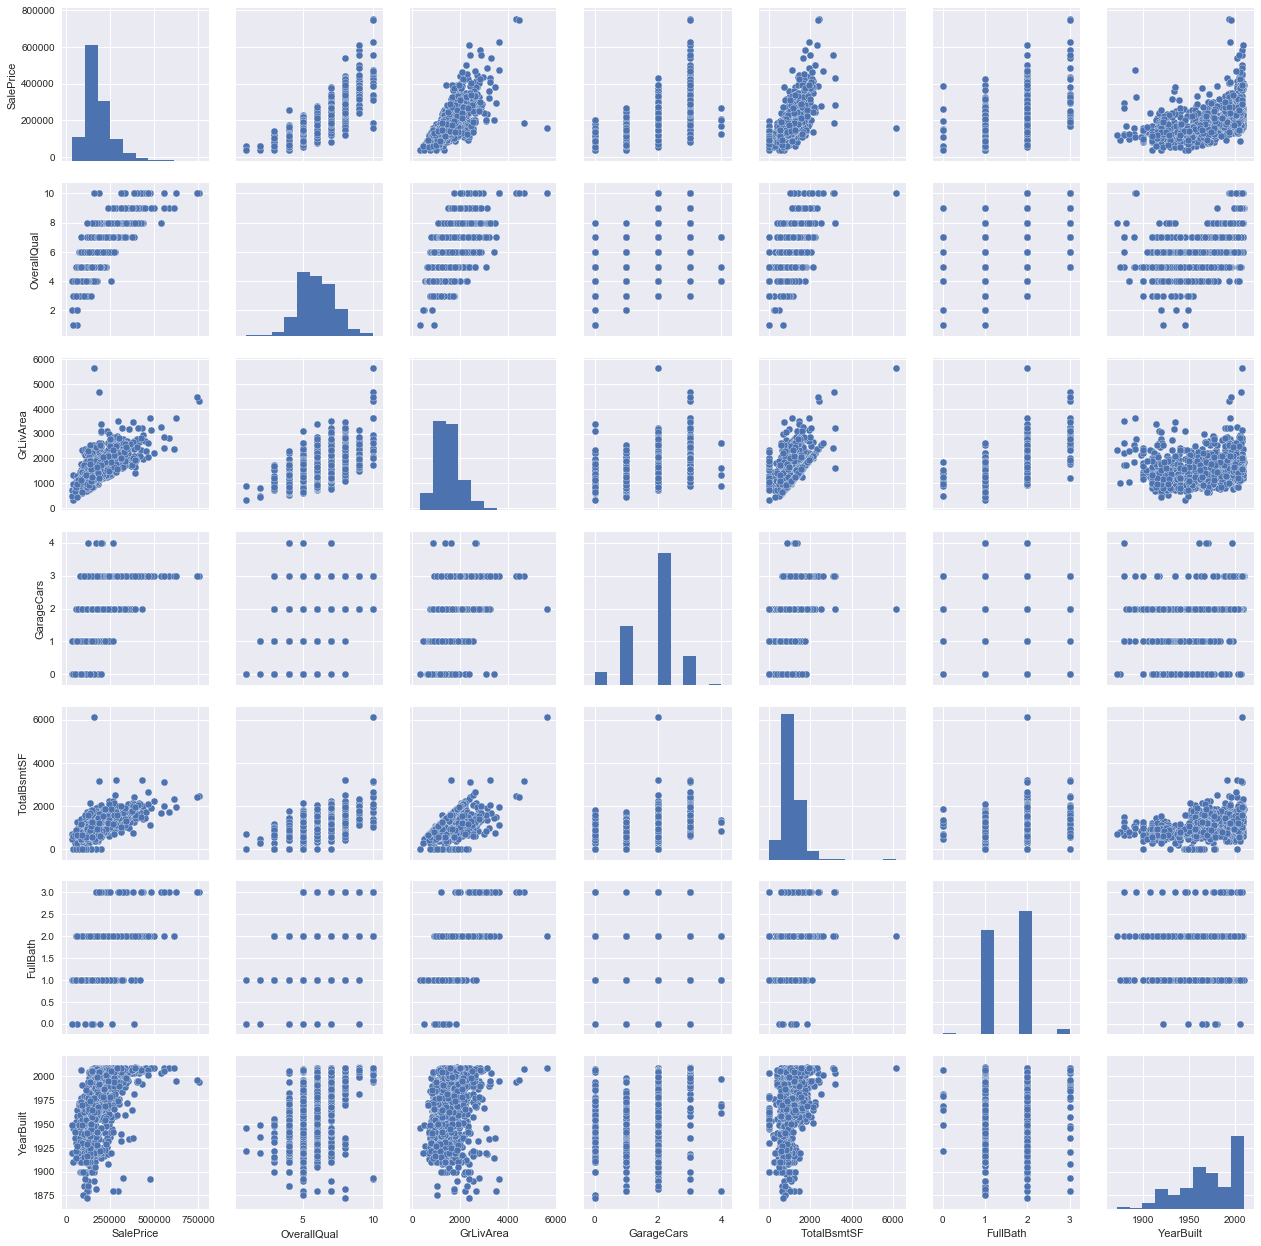

In [31]:
distrub_graph(train,cols = ['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', 'FullBath', 'YearBuilt'])